In [1]:
import numpy as np
import dill
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from evo.core.trajectory import PosePath3D, PoseTrajectory3D
from scipy.spatial.transform import Rotation as Rot
from collections import deque
%matplotlib inline
%matplotlib widget 



# Load the ground truth trajectory
dumpfile = open("../notebooks/Dataset_Syntetic/Sets/1/gt.dill", "rb")
trajectory = dill.load(dumpfile)
dumpfile.close()

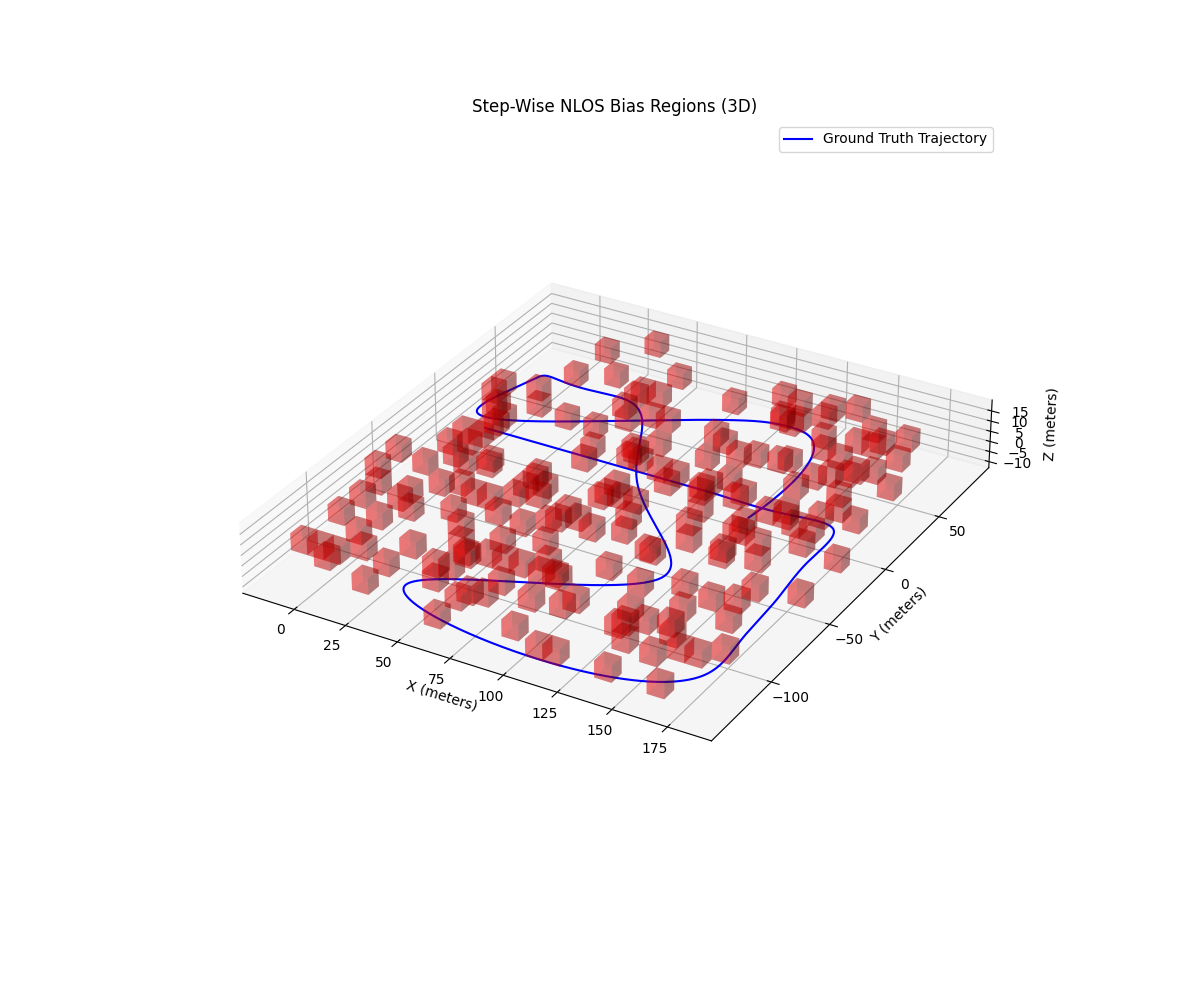

In [5]:
# Extract positions and timestamps from the ground truth trajectory
poses = np.array([pose[:3, 3] for pose in trajectory.poses_se3])  # Extract positions (x, y, z)
rotations = np.array([pose[:3, :3] for pose in trajectory.poses_se3])  # Extract positions (x, y, z)
timestamps = trajectory.timestamps

# Initialize GNSS trajectory
gnss_trajectory = []
gnss_poses_se3 = []

# Noise parameters for random noise (zero mean, Gaussian)
sigma = np.array([0.015, 0.015, 0.035])  # Standard deviation for x, y, z (in meters)
Q = np.diag(sigma**2)  # Covariance matrix for random noise

# Multipath error parameters
A = np.array([0.1, 0.1, 0.1])  # Amplitude for x, y, z (in meters)
lambda_spatial = np.array([50.0, 50.0, 50.0])  # Wavelength for x, y, z (in meters)

# Step-wise bias parameters
grid_size =8.0  # Size of grid cells in meters
amplitude_range = (-20,20)  # Range of step-wise bias amplitudes
coverage_fraction = 0.08  # Fraction of grid cells with step-wise biases
smoothing_size =30  # Size of the smoothing window (number of grid cells)

# Compute grid boundaries
x_min, y_min, z_min = poses[:, 0].min(), poses[:, 1].min(), poses[:, 2].min()
x_max, y_max, z_max = poses[:, 0].max(), poses[:, 1].max(), poses[:, 2].max()
x_steps = int(np.ceil((x_max - x_min) / grid_size)) + 1 
y_steps = int(np.ceil((y_max - y_min) / grid_size)) + 1
z_steps = int(np.ceil((z_max - z_min) / grid_size)) + 1

# Generate step-wise bias regions in a 3D grid
bias_grid = np.zeros((x_steps, y_steps, z_steps, 3))  # Bias grid for x, y, z
for i in range(x_steps):
    for j in range(y_steps):
        for k in range(z_steps):
            if np.random.rand() < coverage_fraction:
                bias_grid[i, j, k] = np.random.uniform(*amplitude_range, size=3)

# Function to compute step-wise NLOS bias
def compute_stepwise_bias(position, grid, x_min, y_min, z_min, grid_size):
    x_idx = int((position[0] - x_min) // grid_size)
    y_idx = int((position[1] - y_min) // grid_size)
    z_idx = int((position[2] - z_min) // grid_size)
    if (
        0 <= x_idx < grid.shape[0]
        and 0 <= y_idx < grid.shape[1]
        and 0 <= z_idx < grid.shape[2]
    ):
        return grid[x_idx, y_idx, z_idx]
    return np.zeros(3)

# Function to compute position-dependent multipath bias
def compute_multipath_bias(position, amplitude, wavelength):
    return amplitude * np.sin(2 * np.pi * position / wavelength)

bias_queue = deque(maxlen=smoothing_size)  # Initialize a fixed-size queue

# Loop through all positions to compute the GNSS trajectory
for i, position in enumerate(poses):
    # Add random Gaussian noise
    noise = np.random.multivariate_normal(mean=np.zeros(3), cov=Q)

    # Compute multipath bias
    multipath_bias = compute_multipath_bias(position, A, lambda_spatial)

    # Compute step-wise NLOS bias
    stepwise_bias = compute_stepwise_bias(position, bias_grid, x_min, y_min, z_min, grid_size)

    # Add the current stepwise_bias to the queue
    bias_queue.append(stepwise_bias)

    # Compute the smoothed bias as the mean of the queue
    smoothed_stepwise_bias = np.mean(bias_queue, axis=0)

    # Add errors to the position
    gnss_position = position  + noise + smoothed_stepwise_bias  + multipath_bias  

    # Rotation
    current_euler_global = Rot.from_matrix(rotations[i]).as_euler('xyz')
    #ToDo add angular noise
    current_rotation = Rot.from_euler('xyz', current_euler_global).as_matrix()

    new_pose = np.eye(4)
    new_pose[:3, :3] = current_rotation
    new_pose[:3, 3] = gnss_position

    gnss_trajectory.append(gnss_position)
    gnss_poses_se3.append(new_pose)

# Convert GNSS trajectory to numpy array
gnss_trajectory = np.array(gnss_trajectory)
gnss_trajectory_evo = PoseTrajectory3D(poses_se3=gnss_poses_se3, timestamps=timestamps)

# Visualization of the bias regions in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the ground truth trajectory
ax.plot(poses[:, 0], poses[:, 1], poses[:, 2], c="blue", label="Ground Truth Trajectory")

# Add step-wise bias regions as cuboids
for i in range(x_steps):
    for j in range(y_steps):
        for k in range(z_steps):
            if np.any(bias_grid[i, j, k] != 0):
                # Create a cuboid for the grid cell
                x_start = x_min + i * grid_size
                y_start = y_min + j * grid_size
                z_start = z_min + k * grid_size

                # Draw cuboid
                ax.bar3d(
                    x_start, y_start, z_start,  # Start position
                    grid_size, grid_size, grid_size,  # Width, Depth, Height
                    color="red", alpha=0.3
                )

# Label axes
ax.set_title("Step-Wise NLOS Bias Regions (3D)")
ax.set_xlabel("X (meters)")
ax.set_ylabel("Y (meters)")
ax.set_zlabel("Z (meters)")
ax.set_aspect("equal")

# Add legend and grid
ax.legend()
ax.grid(True)

# Show the plot
plt.show()

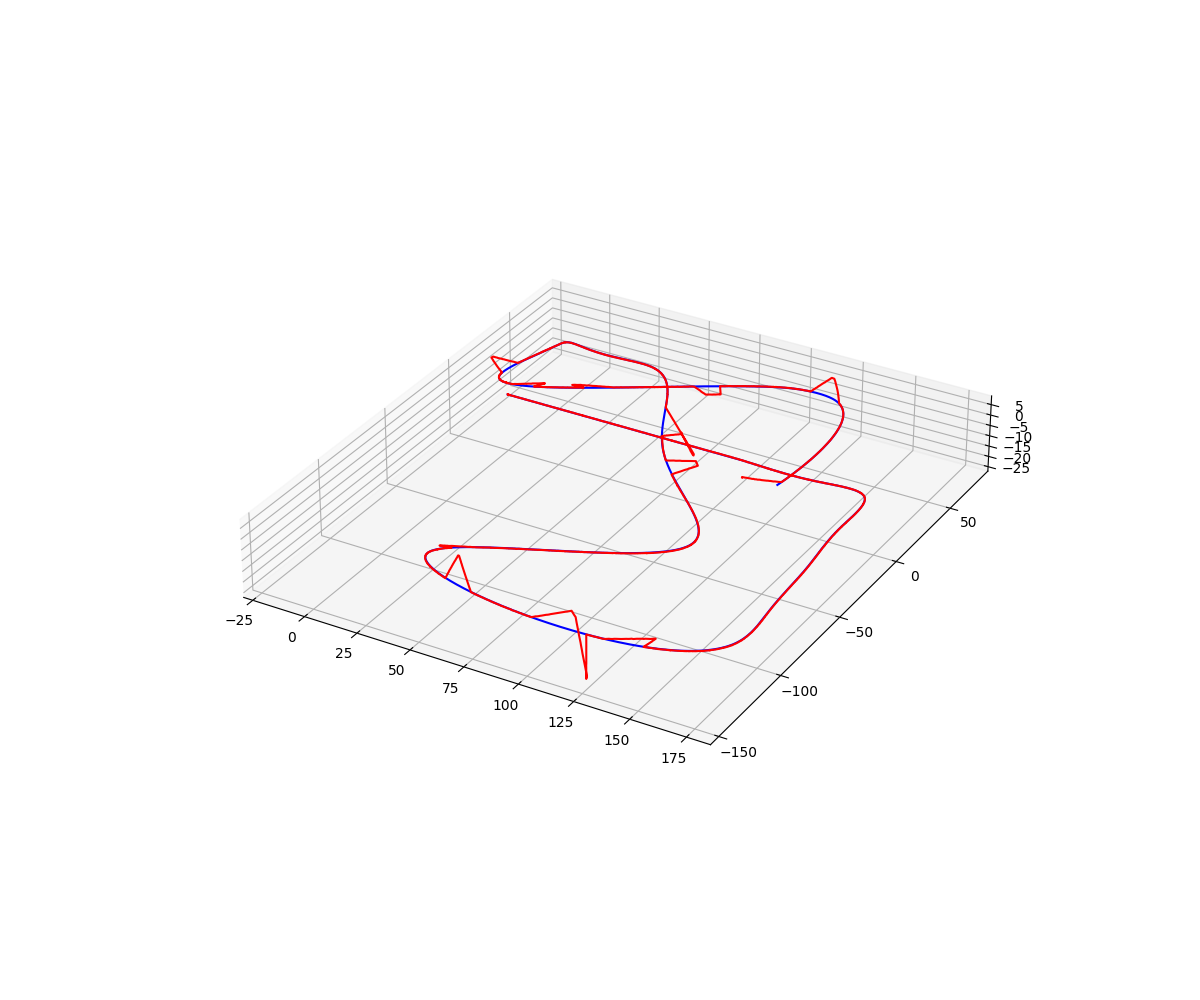

In [6]:
# Visualization of the bias regions in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the ground truth trajectory
ax.plot(poses[:, 0], poses[:, 1], poses[:, 2], c="blue", label="Ground Truth Trajectory")
ax.plot(gnss_trajectory[:, 0], gnss_trajectory[:, 1], gnss_trajectory[:, 2], c="red", label="Ground Truth Trajectory")
ax.set_aspect("equal")

In [7]:
gnss_trajectory_evo.meta["Name"] = "gnss"
gnss_trajectory_evo.meta["topic"] = "/odom_gnss"
gnss_trajectory_evo.meta["frame_id"] = "map"
gnss_trajectory_evo.meta["child_frame_id"] = "base_link"
gnss_trajectory_evo.meta["publish_transform"] = False
gnss_trajectory_evo.meta["publish_orientation"] = True
gnss_trajectory_evo.meta["frequency"] = 10

# Save the GNSS trajectory
output_file = "../notebooks/Dataset_Syntetic/Sets/1/gnss.dill"
with open(output_file, "wb") as f:
    dill.dump(gnss_trajectory_evo, f)

print(f"GNSS trajectory saved to {output_file}")

gnss_trajectory_evo.meta["frequency"] = 5

# Save the GNSS trajectory
output_file = "../notebooks/Dataset_Syntetic/Sets/1/gnss_half_speed.dill"
with open(output_file, "wb") as f:
    dill.dump(gnss_trajectory_evo, f)

print(f"GNSS trajectory saved to {output_file}")

GNSS trajectory saved to ../notebooks/Dataset_Syntetic/Sets/1/gnss.dill
GNSS trajectory saved to ../notebooks/Dataset_Syntetic/Sets/1/gnss_half_speed.dill
